In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
from gymnasium import spaces
import pickle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os
import cv2


In [11]:
doubleMrewards_drone = []
doubleMrewards_cart = []
doubleMrewards_lake = []

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class DoubleDQNAgent:
    def __init__(self, input_dim, output_dim):
        self.qnet = QNetwork(input_dim, output_dim)                  #I have almost kept this same as DQN class, we need to first initilize online and target networks
        self.targetnet = QNetwork(input_dim, output_dim)
        self.targetnet.load_state_dict(self.qnet.state_dict())             #making the weights of both networks same
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)       #initializing the buffer to store the experiences
        self.batchSize = 64
        self.gamma = 0.99
        self.epsi = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.updateTar = 100
        self.stepsCount = 0

    def actionFun(self, state):         #We take action according to the epsilon greedy policy
        if np.random.rand() < self.epsi:
            return np.random.randint(self.qnet.fc3.out_features)
        with torch.no_grad():
            q_values = self.qnet(state)
            return torch.argmax(q_values).item()

    def addExptoBuff(self, state, action, reward, nxt_st, done):   #Function which just stores the experiences to the buffer
        self.memory.append((state, action, reward, nxt_st, done))

    def replay(self):
        if len(self.memory) < self.batchSize:
            return
        
        batch = random.sample(self.memory, self.batchSize)        #Taking random 64 samples from the buffer
        states, actions, rewards, nxt_states, dones = zip(*batch)
        states = torch.stack(states)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32) #Converting all the things to tensor
        nxt_states = torch.stack(nxt_states)
        dones = torch.tensor(dones, dtype=torch.float32)
        current_q = self.qnet(states).gather(1, actions.unsqueeze(1)).squeeze(1)   #getting corrosponding qvalues of action (predicting it through network)
        next_actions = self.qnet(nxt_states).argmax(1)          #selecting best action with online q network
        next_q = self.targetnet(nxt_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)   #taking the above action and getting the qvalues from target network
        target_q = rewards + self.gamma * next_q * (1 - dones)
        loss = nn.functional.mse_loss(current_q, target_q)   #taking the mse loss
        self.optimizer.zero_grad()          #clearing the grad
        loss.backward()
        self.optimizer.step()            #calcuating the grad values
        self.epsi = max(self.epsilon_min, self.epsi * self.epsilon_decay)     #epsilon decay 
        self.stepsCount += 1
        if self.stepsCount >= self.updateTar:
            self.targetnet.load_state_dict(self.qnet.state_dict())
            self.stepsCount = 0




In [13]:
class AutoDrone(gym.Env):
    def __init__(self):
        super(AutoDrone, self).__init__()
        self.grid_size = 6
        self.action_space = spaces.Discrete(6)
        self.obs_space = spaces.Tuple((spaces.Discrete(self.grid_size),spaces.Discrete(self.grid_size),spaces.Discrete(2)))
        self.warehouse = (0, 0)
        self.delivery = (5, 5)
        self.nofly = {(2,2), (2,3), (3,2), (3,3)}
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        while True:
            self.pos = (self.np_random.integers(6), self.np_random.integers(6))
            if self.pos not in self.nofly: break
        self.has_package = False
        return (self.pos[0], self.pos[1], int(self.has_package)), {}

    def step(self, action):
        x, y = self.pos
        reward = -1
        terminated = False
        if action < 4:
            new_pos = [(x, min(y+1, 5)), (x, max(y-1, 0)),(max(x-1, 0), y), (min(x+1, 5), y)][action]
            if new_pos in self.nofly:
                reward = -100
                terminated = True
            else:
                self.pos = new_pos
        elif action == 4:  # Pick
            if self.pos == self.warehouse and not self.has_package:
                self.has_package = True
                reward = 25
            else:
                reward = -10
        elif action == 5:  # Drop
            if self.pos == self.delivery and self.has_package:
                reward = 100
                terminated = True
            else:
                reward = -10
        return (self.pos[0], self.pos[1], int(self.has_package)), reward, terminated, False, {}
    
    def render(self, mode='human', plot=False):
        fig, ax = plt.subplots()

        def plot_image(plot_pos):
            drone = False
            droneAndpackage = False
            warehouse = False
            delivery_point = False
            noFlyZ = False
            cld = False

            fixed_size = (60, 50)  
            def preprocessImg(image_path):
                normalized_path = os.path.normpath(image_path)
                if not os.path.exists(normalized_path):
                    print(f"Error: Image not found at {normalized_path}")
                    return None
                img = plt.imread(normalized_path)
                resized_img = cv2.resize(img, fixed_size, interpolation=cv2.INTER_AREA)
                return resized_img

            plot_pos = np.array(plot_pos)
            if np.array_equal(plot_pos, self.pos) and not self.has_package:
                drone = True
            elif np.array_equal(plot_pos, self.pos) and self.has_package:
                droneAndpackage = True
            elif np.array_equal(plot_pos, self.warehouse):
                warehouse = True
            elif np.array_equal(plot_pos, self.delivery):
                delivery_point = True
            elif tuple(plot_pos) in self.nofly:
                noFlyZ = True
            else:
                cld = True

            if drone and all(not item for item in [droneAndpackage, warehouse, delivery_point, noFlyZ, cld]):
                drone_img = preprocessImg('./images/drone.jpg')
                if drone_img is not None:
                    drone_box = AnnotationBbox(OffsetImage(drone_img, zoom=1), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(drone_box)

            elif droneAndpackage and all(not item for item in [drone, warehouse, delivery_point, noFlyZ, cld]):
                drone_package_img = preprocessImg('./images/drone+package.jpg')
                if drone_package_img is not None:
                    drone_package_box = AnnotationBbox(OffsetImage(drone_package_img, zoom=1), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(drone_package_box)

            elif warehouse and all(not item for item in [drone, droneAndpackage, delivery_point, noFlyZ, cld]):
                warehouse_img = preprocessImg('./images/warehouse.jpg')
                if warehouse_img is not None:
                    warehouse_box = AnnotationBbox(OffsetImage(warehouse_img, zoom=1), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(warehouse_box)

            elif delivery_point and all(not item for item in [drone, droneAndpackage, warehouse, noFlyZ, cld]):
                delivery_img = preprocessImg('./images/deliveryHouse.jpg')
                if delivery_img is not None:
                    delivery_box = AnnotationBbox(OffsetImage(delivery_img, zoom=1), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(delivery_box)

            elif noFlyZ and all(not item for item in [drone, droneAndpackage, warehouse, delivery_point, cld]):
                nofly_img = preprocessImg('./images/noflyzone.jpg')
                if nofly_img is not None:
                    nofly_box = AnnotationBbox(OffsetImage(nofly_img, zoom=1), np.add(plot_pos, [0.5, 0.5]), frameon=False) 
                    ax.add_artist(nofly_box)

            elif cld and all(not item for item in [drone, droneAndpackage, warehouse, delivery_point, noFlyZ]):
                cld_img = preprocessImg('./images/clouds.jpg')
                if cld_img is not None:
                    cld_box = AnnotationBbox(OffsetImage(cld_img, zoom=1),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(cld_box)

        mapping = {}
        for j in range(self.grid_size * self.grid_size):
            mapping[j] = np.array([j % self.grid_size, int(np.floor(j / self.grid_size))])

        for position in mapping:
            plot_image(mapping[position])
        plt.xticks(range(self.grid_size + 1))
        plt.yticks(range(self.grid_size + 1))
        plt.grid()
        plt.title('Drone Environment')

        if plot:
            plt.show()
        else:
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = height = 100
            preprocessed_image = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
            plt.show()
            plt.pause(0.1)
            return preprocessed_image

def processDronestate(obs):
    x, y, package = obs
    return torch.tensor([x/5.0, y/5.0, package], dtype=torch.float32)   #we are normalizing the x and y to make the values between 0 and 1

In [14]:
def train_autodrone(agent, episodes=1000):
    env = AutoDrone()
    global doubleMrewards_drone
    doubleMepsi_drone = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = processDronestate(state)
        totalReward = 0
        done = False
        
        while not done:
            action = agent.actionFun(state)
            nxt_st, reward, done, _, _ = env.step(action)
            nxt_st = processDronestate(nxt_st) 
            agent.addExptoBuff(state, action, reward, nxt_st, done)
            agent.replay()
            state = nxt_st
            totalReward += reward 
        doubleMrewards_drone.append(totalReward)
        doubleMepsi_drone.append(agent.epsi)
        if (episode+1) % 100 == 0:
            avg = np.mean(doubleMrewards_drone[-100:])
            print(f"The episode number is {episode+1} for this we got average reward as: {avg:.2f} and the current epsilon value is: {agent.epsi:.2f}")
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(doubleMrewards_drone)
    plt.title(f"{env} Training rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    
    plt.subplot(1,2,2)
    plt.plot(doubleMepsi_drone)
    plt.title("Epsilon Decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.show()
    plt.close()
    return agent

In [15]:
def processPolestate(obs):
    return torch.tensor(obs, dtype=torch.float32)

def train_cartpole(episodes=500):
    env = gym.make('CartPole-v1')
    assert env.spec.max_episode_steps == 500, "Max episode steps should be 500"
    agent = DoubleDQNAgent(input_dim=4, output_dim=2)
    global doubleMrewards_cart
    doubleMepsi_cart = []
    for episode in range(episodes):
        state, _ = env.reset()  
        state = processPolestate(state)
        totalReward = 0
        while True:
            action = agent.actionFun(state)
            nxt_st, reward, terminated, truncated, _ = env.step(action)  
            nxt_st = processPolestate(nxt_st)
            done = terminated or truncated 
            agent.addExptoBuff(state, action, reward, nxt_st, done)
            agent.replay()
            state = nxt_st
            totalReward += reward
            if done:
                break  
        doubleMrewards_cart.append(totalReward)
        doubleMepsi_cart.append(agent.epsi)  

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(doubleMrewards_cart[-100:])
            print(f"The episode number {episode+1} is done and we got avg reward as: {avg_reward:.2f} and current value of epsilon: {agent.epsi:.2f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(doubleMrewards_cart)
    plt.title(f"{env} Training rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.subplot(1,2,2)
    plt.plot(doubleMepsi_cart)
    plt.title("Epsilon Decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.show()
    plt.close()

    return agent

In [41]:
def processLakestate(obs):
    state = np.zeros(16)
    state[obs] = 1.0
    return torch.tensor(state, dtype=torch.float32)

def train_frozenlake(episodes=2000):
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
    agent = DoubleDQNAgent(input_dim=16, output_dim=4)
    global doubleMrewards_lake
    doubleMepsi_lake = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = processLakestate(state)
        totalReward = 0
        done = False   
        while not done:
            action = agent.actionFun(state)
            nxt_st, reward, done, _, _ = env.step(action)   
            if done and reward == 0:
                reward = -1
            elif done and reward == 1: 
                reward = 10
            else: 
                reward = -0.01 
            nxt_st = processLakestate(nxt_st)
            agent.addExptoBuff(state, action, reward, nxt_st, done)
            agent.replay() 
            state = nxt_st
            totalReward += reward
        doubleMrewards_lake.append(totalReward)
        doubleMepsi_lake.append(agent.epsi)
        if (episode+1) % 100 == 0:
            avg = np.mean(doubleMrewards_lake[-100:])
            print(f"For the episode {episode+1} we got avg reward as: {avg:.2f} and the current value for epsilon is: {agent.epsi:.2f}")
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(doubleMrewards_lake)
    plt.title(f"{env} Training rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.subplot(1,2,2)
    plt.plot(doubleMepsi_lake)
    plt.title("Epsilon Decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.show()
    plt.close()
    return agent

The episode number is 100 for this we got average reward as: -784.54 and the current epsilon value is: 0.01
The episode number is 200 for this we got average reward as: 55.52 and the current epsilon value is: 0.01
The episode number is 300 for this we got average reward as: -318.08 and the current epsilon value is: 0.01
The episode number is 400 for this we got average reward as: 100.93 and the current epsilon value is: 0.01
The episode number is 500 for this we got average reward as: 107.87 and the current epsilon value is: 0.01
The episode number is 600 for this we got average reward as: 108.87 and the current epsilon value is: 0.01
The episode number is 700 for this we got average reward as: 105.21 and the current epsilon value is: 0.01
The episode number is 800 for this we got average reward as: 102.60 and the current epsilon value is: 0.01
The episode number is 900 for this we got average reward as: 108.80 and the current epsilon value is: 0.01
The episode number is 1000 for this 

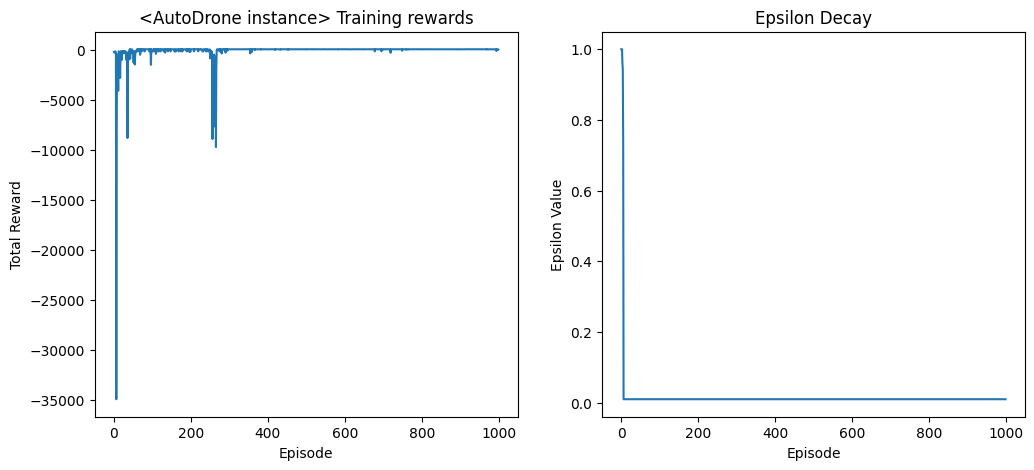

In [17]:
agent = DoubleDQNAgent(input_dim=3, output_dim=6)
autodrone_agent = train_autodrone(agent)
torch.save(autodrone_agent.qnet.state_dict(), 'autodroneDouble.pth')
model_weights = autodrone_agent.qnet.state_dict()
with open("doubledroneModel_weights.pkl", "wb") as f:
    pickle.dump(model_weights, f)

The episode number 100 is done and we got avg reward as: 255.97 and current value of epsilon: 0.01
The episode number 200 is done and we got avg reward as: 416.40 and current value of epsilon: 0.01
The episode number 300 is done and we got avg reward as: 327.42 and current value of epsilon: 0.01
The episode number 400 is done and we got avg reward as: 363.03 and current value of epsilon: 0.01
The episode number 500 is done and we got avg reward as: 376.38 and current value of epsilon: 0.01


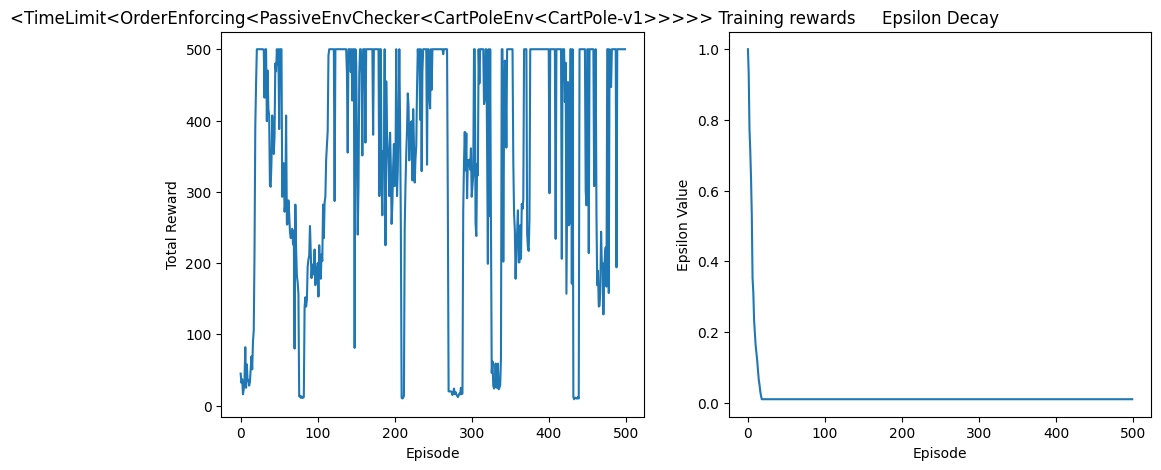

In [18]:
cartpole_ddagent = train_cartpole()
torch.save(cartpole_ddagent.qnet.state_dict(), 'cartpoledouble.pth')
model_weights = cartpole_ddagent.qnet.state_dict()
with open("cartPoledoubleModel_weights.pkl", "wb") as f:
    pickle.dump(model_weights, f)

For the episode 100 we got avg reward as: -2.24 and the current value for epsilon is: 0.01
For the episode 200 we got avg reward as: 7.52 and the current value for epsilon is: 0.01
For the episode 300 we got avg reward as: 8.51 and the current value for epsilon is: 0.01
For the episode 400 we got avg reward as: 9.73 and the current value for epsilon is: 0.01
For the episode 500 we got avg reward as: 9.84 and the current value for epsilon is: 0.01
For the episode 600 we got avg reward as: 9.95 and the current value for epsilon is: 0.01
For the episode 700 we got avg reward as: 9.84 and the current value for epsilon is: 0.01
For the episode 800 we got avg reward as: 9.84 and the current value for epsilon is: 0.01
For the episode 900 we got avg reward as: 9.84 and the current value for epsilon is: 0.01
For the episode 1000 we got avg reward as: 9.84 and the current value for epsilon is: 0.01
For the episode 1100 we got avg reward as: 9.79 and the current value for epsilon is: 0.01
For the

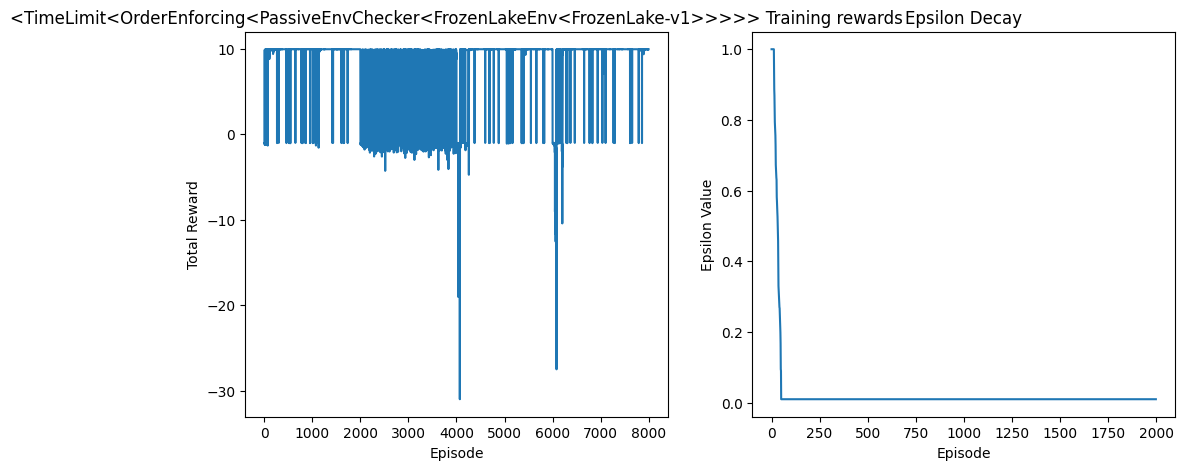

In [43]:
frozenlake_ddagent = train_frozenlake()
torch.save(frozenlake_ddagent.qnet.state_dict(), 'frozenlakedouble.pth')
model_weights = frozenlake_ddagent.qnet.state_dict()
with open("frozenLakedoubleModel_weights.pkl", "wb") as f:
    pickle.dump(model_weights, f)

In [20]:
def rendFun(agent):
    env = AutoDrone()
    state, _ = env.reset()
    frames = []
    env.curr_pos = env.pos
    env.package = env.has_package
    env.grid_s = env.grid_size
    env.warehouse_loc = env.warehouse
    env.delivery_loc = env.delivery

    while True:
        env.curr_pos = env.pos
        env.package = env.has_package
        frame = env.render(mode='rgb_array', plot=False)
        frames.append(Image.fromarray(frame))
        with torch.no_grad():
            q_values = agent.qnet(processDronestate(state))
            action = torch.argmax(q_values).item()
        next_state, reward, done, _, _ = env.step(action)
        state = next_state

        if done:
            break
    frames[0].save('autodrone_episode.gif', save_all=True, append_images=frames[1:], duration=500, loop=0)

In [21]:
def evalAgents(env, agent, process_state, episodes=5, env_name="Environment"):
    total_rewards = []
    
    for ep in range(episodes):
        obs, info = env.reset()
        state = process_state(obs)
        total_reward = 0
        terminated = False
        truncated = False
        while not (terminated or truncated):
            with torch.no_grad():
                state_tensor = state.unsqueeze(0) if state.dim() == 1 else state
                q_values = agent.qnet(state_tensor)
                action = torch.argmax(q_values).item()
            next_obs, reward, terminated, truncated, info = env.step(action)
            state = process_state(next_obs)
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Episode {ep+1}: Reward = {total_reward}")
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, episodes+1), total_rewards)  
    plt.title(f"Evaluation Results for {env_name}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.xticks(range(1, episodes+1))
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{env_name}.png")
    plt.close()
    
    return total_rewards

In [22]:
cartpole_env = gym.make("CartPole-v1", render_mode="rgb_array")
frozenlake_env = gym.make("FrozenLake-v1", render_mode="rgb_array")
autodrone_env = AutoDrone()

In [38]:
cartpole_rewards = evalAgents(cartpole_env, cartpole_ddagent, processPolestate, env_name="cartpoledouble")
frozenlake_rewards = evalAgents(frozenlake_env, frozenlake_ddagent, processLakestate, env_name="FrozenLakedouble")
autodrone_rewards = evalAgents(autodrone_env, autodrone_agent, processDronestate,env_name="AutoDronedouble")

Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Episode 1: Reward = 0.0
Episode 2: Reward = 1.0
Episode 3: Reward = 0.0
Episode 4: Reward = 0.0
Episode 5: Reward = 0.0
Episode 1: Reward = 108
Episode 2: Reward = 106
Episode 3: Reward = 110
Episode 4: Reward = 107
Episode 5: Reward = 115


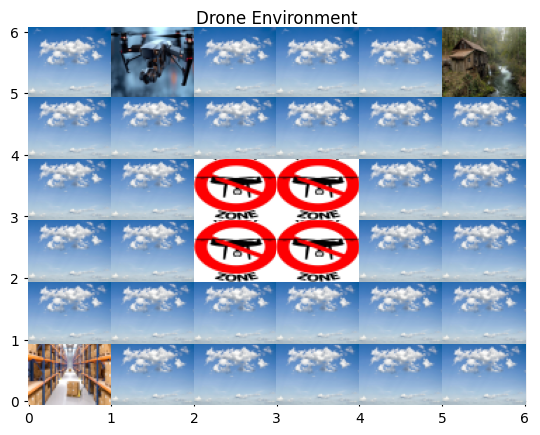

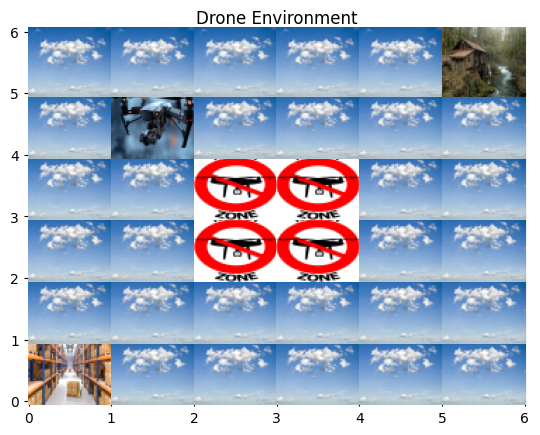

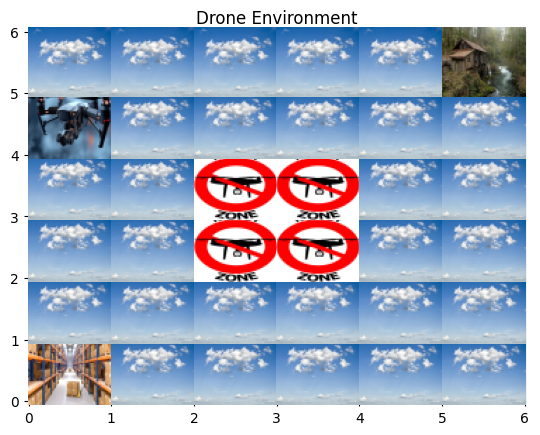

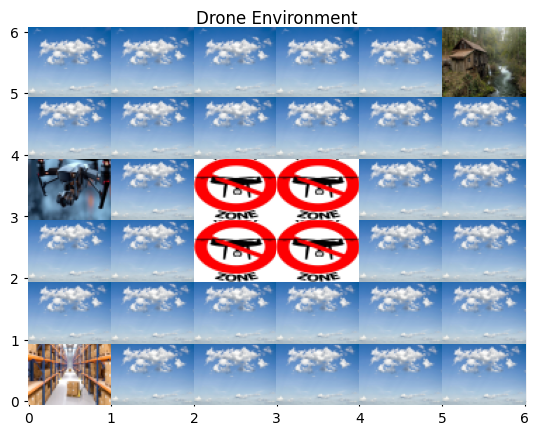

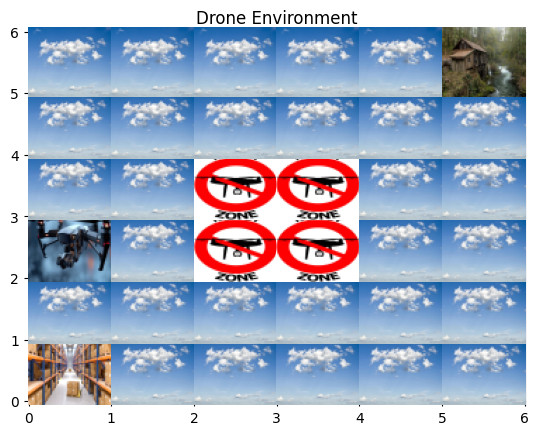

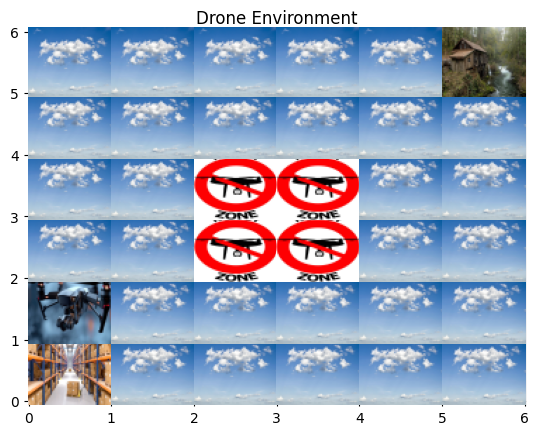

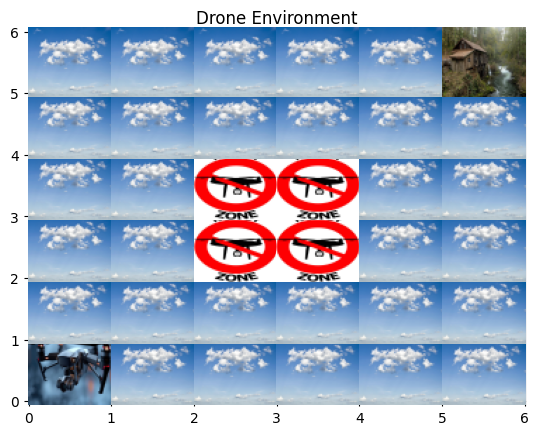

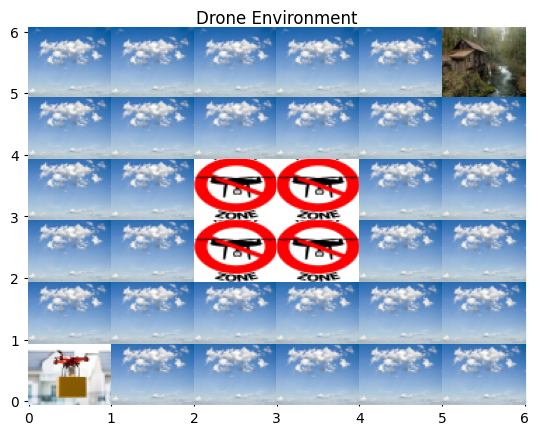

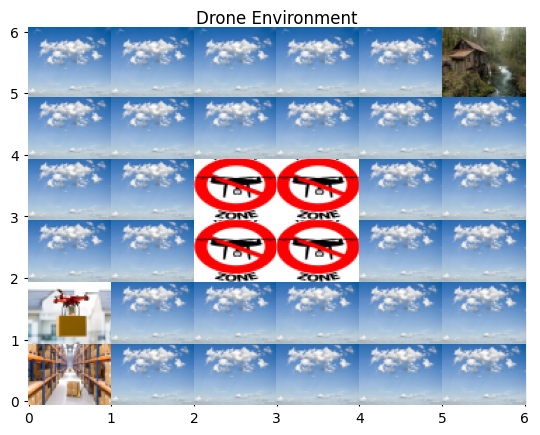

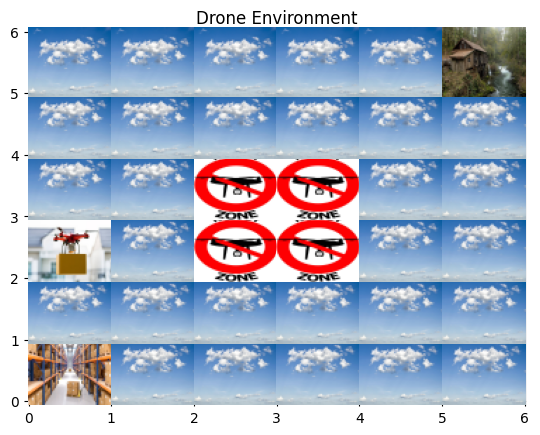

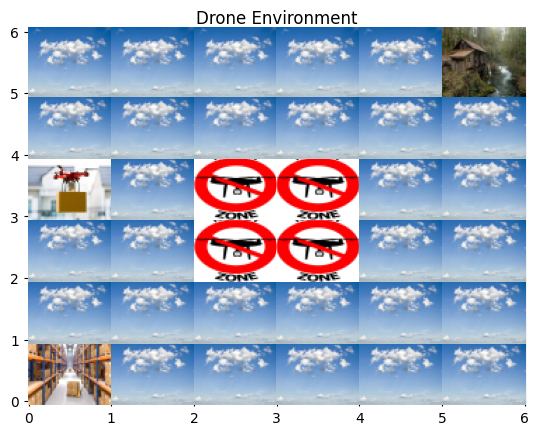

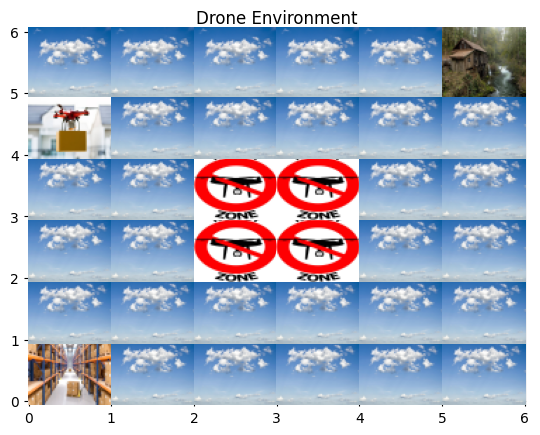

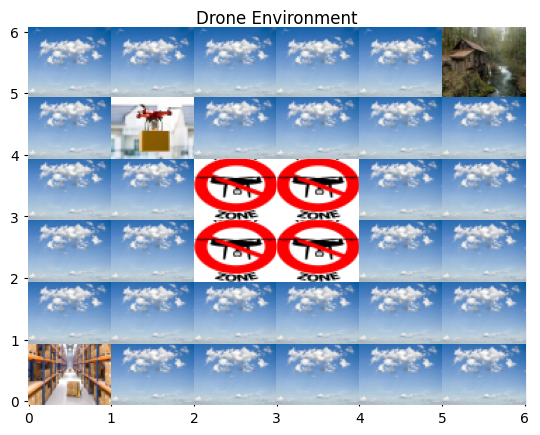

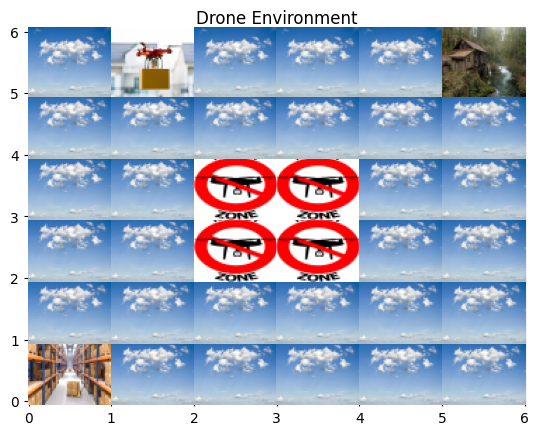

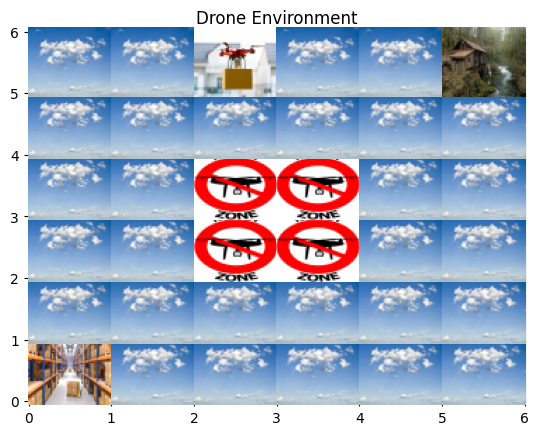

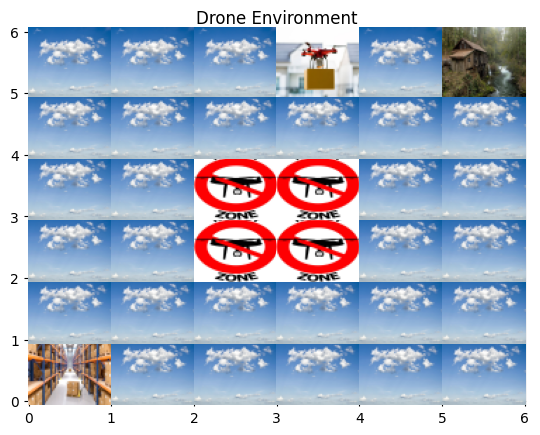

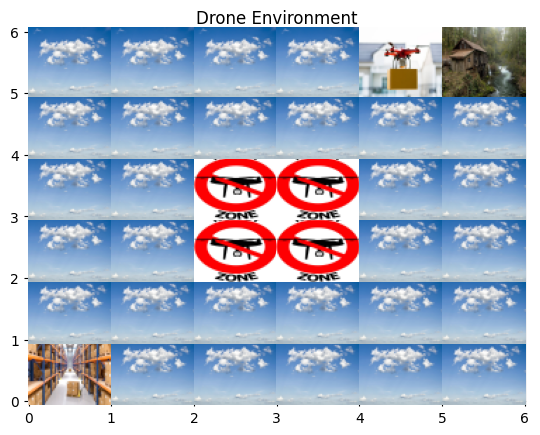

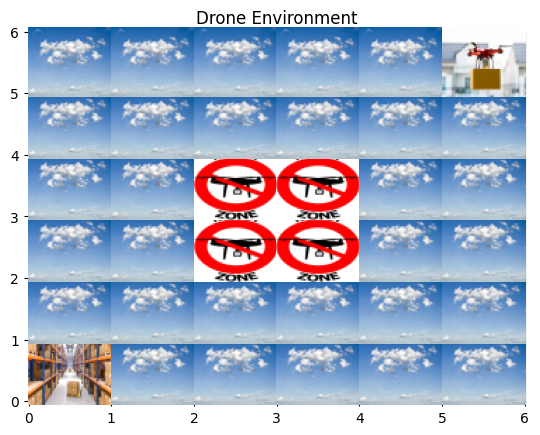

In [24]:
rendFun(autodrone_agent)

In [25]:
Dronedqn_rewards = np.load("droneDQN_rewards.npy")
cartdqn_rewards = np.load("cartdqn_rewards.npy")           #loading the rewards from DQN to plot graph and compare it with DOubleDQN
lakedqn_rewards = np.load("lakedqn_rewards.npy")


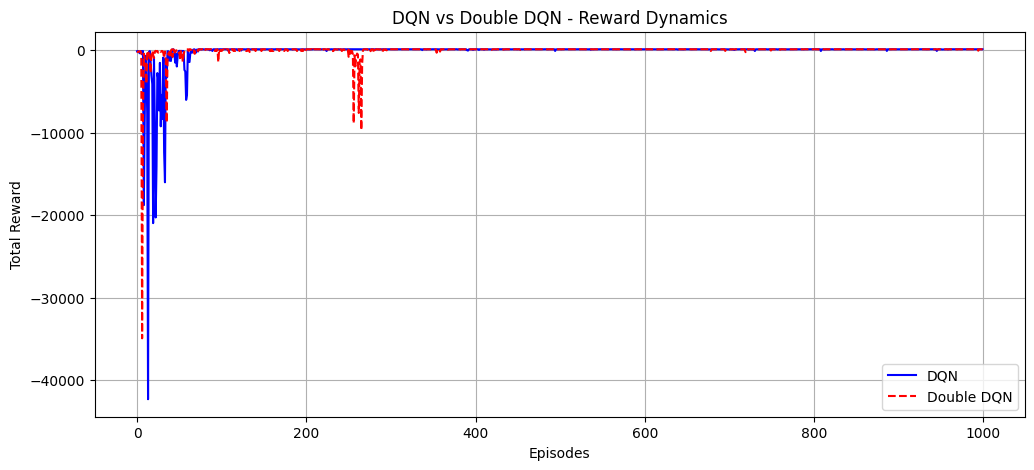

In [26]:
min_length = min(len(Dronedqn_rewards), len(doubleMrewards_drone))
Dronedqn_rewards = Dronedqn_rewards[:min_length]
doubleMrewards_drone = doubleMrewards_drone[:min_length]
episodes = np.arange(min_length)
plt.figure(figsize=(12, 5))
plt.plot(episodes, Dronedqn_rewards, label="DQN", color='blue')
plt.plot(episodes, doubleMrewards_drone, label="Double DQN", color='red', linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN - Reward Dynamics")
plt.legend()
plt.grid()
plt.show()

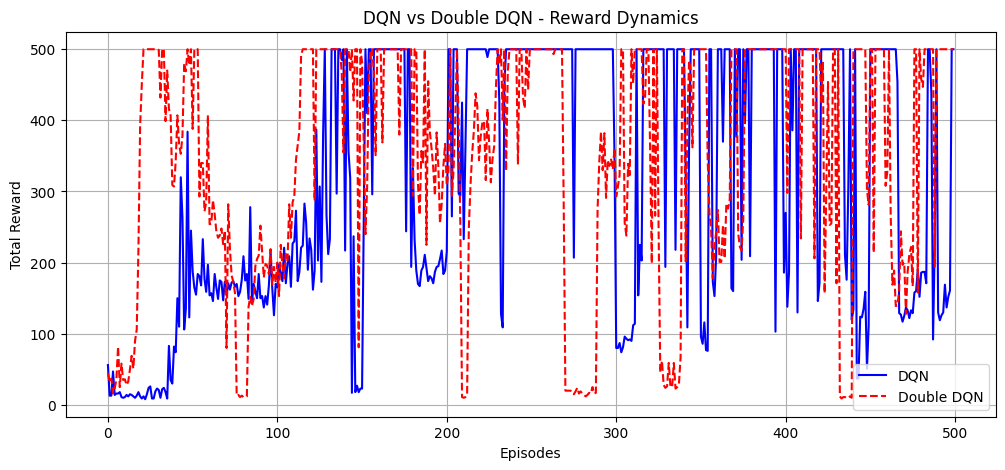

In [27]:
min_length = min(len(cartdqn_rewards), len(doubleMrewards_cart))
cartdqn_rewards = cartdqn_rewards[:min_length]
doubleMrewards_cart = doubleMrewards_cart[:min_length]
episodes = np.arange(min_length)
plt.figure(figsize=(12, 5))
plt.plot(episodes,cartdqn_rewards, label="DQN", color='blue')
plt.plot(episodes, doubleMrewards_cart, label="Double DQN", color='red', linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN - Reward Dynamics")
plt.legend()
plt.grid()
plt.show()

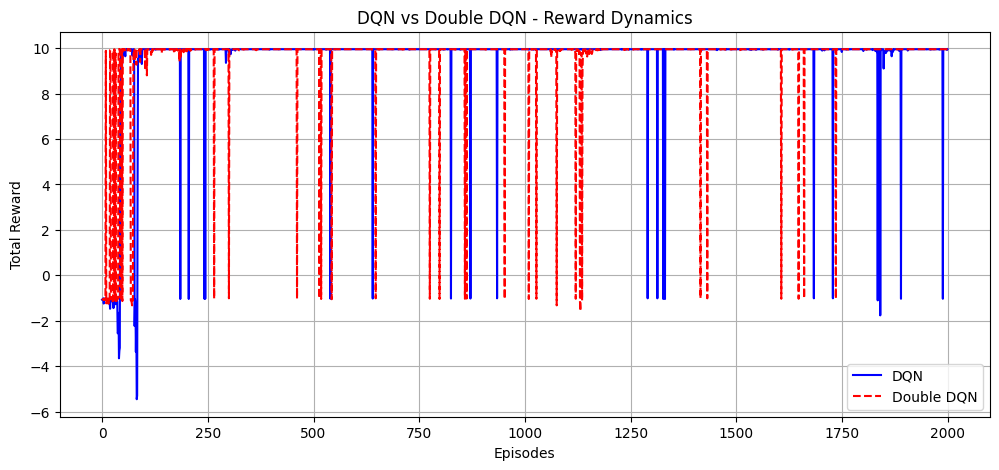

In [29]:
min_length = min(len(lakedqn_rewards), len(doubleMrewards_lake))
lakedqn_rewards = lakedqn_rewards[:min_length]
doubleMrewards_lake = doubleMrewards_lake[:min_length]
episodes = np.arange(min_length)
plt.figure(figsize=(12, 5))
plt.plot(episodes, lakedqn_rewards, label="DQN", color='blue')
plt.plot(episodes, doubleMrewards_lake, label="Double DQN", color='red', linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN - Reward Dynamics")
plt.legend()
plt.grid()
plt.show()